# Set-up of the project

In [13]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

# Packages for data preparation
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>


In [14]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 30  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

Set some parameters that will be used throughout the notebook.

We read in the csv with the tweets data and perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. We'll only keep the video decription column as input and the Relvancy column as the target.

In [25]:
df = pd.read_csv('normal_handlabel_feature.csv')
df.columns
df = df[df['attitude'] != 0]

In [26]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    stopwords_list.append('The')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = str(input_text).split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)


       
df.transcript = df.transcript.apply(remove_stopwords).apply(remove_mentions)
df.head()




,Unnamed: 0,video_id,attitude,transcript,var_r,var_g,var_b,var_h,var_s,var_v,...,median_r,median_g,median_b,median_h,median_s,median_v,median_bright,median_bright_sd,median_contrast,median_colorful
5,5,8ocWUAwQMhY,1,hi guys Daniel Alexander cannon logic Authorit...,611.670255,710.533599,704.285521,565.782339,267.640542,616.471287,...,178.297660,182.070140,183.746428,67.315794,5.285804,184.217756,181.100160,92.073127,255.0,10.850100
7,7,m63EyxOC7KM,1,New York new hot 97 app Ebro morning markets a...,452.356980,478.186275,419.175631,355.090668,468.120127,488.873792,...,58.932432,48.911764,50.621008,91.027888,61.974344,60.291964,52.098780,57.203108,223.0,22.048810
10,10,lXnLwtAS6Fk,1,5g 5g Network that's taking people completely ...,255.602928,227.562307,115.534510,82.652435,56.376545,233.168950,...,162.885660,127.777572,135.631998,73.192558,136.100062,191.345718,139.447290,43.736392,183.0,102.317861
21,22,3dGe2FXOQOw,1,hey guys welcome show today we're gonna discus...,346.926190,328.023541,306.858307,148.598571,82.680316,307.033028,...,199.799596,195.907756,194.418024,27.569884,9.146088,199.960340,196.905496,33.385873,135.0,12.993900
28,29,3ajBR3R8doM,1,hey everyone I'm I'm Shawn oh we've got bit ey...,29.583790,22.456832,16.950847,20.298046,39.189503,29.754383,...,143.555642,127.917176,135.183554,54.865530,46.820690,151.462780,133.429320,69.593465,226.0,47.625559


In [27]:
X = df[['transcript']]

In [28]:
X

,transcript
5,hi guys Daniel Alexander cannon logic Authorit...
7,New York new hot 97 app Ebro morning markets a...
10,5g 5g Network that's taking people completely ...
21,hey guys welcome show today we're gonna discus...
28,hey everyone I'm I'm Shawn oh we've got bit ey...
...,...
727,CaptionUnavailable
728,CaptionUnavailable
729,kovat 19 Diagnostics performing nasopharyngeal...
730,anyone anyone thinking taking chances take loo...


In [29]:
X = X[(X["transcript"] != 'CaptionUnavailable') & (X["transcript"] != 'VideoUnavailable')]

In [30]:
X.shape

(460, 1)

In [31]:
X

,transcript
5,hi guys Daniel Alexander cannon logic Authorit...
7,New York new hot 97 app Ebro morning markets a...
10,5g 5g Network that's taking people completely ...
21,hey guys welcome show today we're gonna discus...
28,hey everyone I'm I'm Shawn oh we've got bit ey...
...,...
725,hey guys Trisha Trish advisor today gonna diff...
726,personal protective equipment including masks ...
729,kovat 19 Diagnostics performing nasopharyngeal...
730,anyone anyone thinking taking chances take loo...


In [32]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['attitude'] = le.fit_transform(df['attitude'])

In [33]:
y = df['attitude'][(df["transcript"] != 'CaptionUnavailable') & (df["transcript"] != 'VideoUnavailable')]
y

5      0
7      0
10     0
21     0
28     0
      ..
725    1
726    1
729    1
730    1
731    1
Name: attitude, Length: 460, dtype: int64

# Data preparation

## Data cleaning

The first thing we'll do is removing stopwords. These words do not have any value for predicting the sentiment.Also, we remove the http link in the texts

In [34]:
visual = df[['var_r', 'var_g', 'var_b',
       'var_h', 'var_s', 'var_v', 'var_bright', 'var_bright_sd',
       'var_contrast', 'var_colorful', 'median_r', 'median_g', 'median_b',
       'median_h', 'median_s', 'median_v', 'median_bright', 'median_bright_sd',
       'median_contrast', 'median_colorful']][(df["transcript"] != 'CaptionUnavailable') & (df["transcript"] != 'VideoUnavailable')]

In [35]:
NB_WORDS = 10000
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X.transcript)

In [36]:
x_seq = tk.texts_to_sequences(X.transcript)

In [37]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

In [38]:
X_oh = one_hot_seq(x_seq)

In [39]:
visual.shape

(460, 20)

In [40]:
X_oh.shape

(460, 10000)

In [41]:
result = pd.DataFrame(pd.np.column_stack([visual, X_oh]))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [42]:
result.head

<bound method NDFrame.head of            0            1            2           3           4      \
0     611.670255   710.533599   704.285521  565.782339  267.640542   
1     452.356980   478.186275   419.175631  355.090668  468.120127   
2     255.602928   227.562307   115.534510   82.652435   56.376545   
3     346.926190   328.023541   306.858307  148.598571   82.680316   
4      29.583790    22.456832    16.950847   20.298046   39.189503   
..           ...          ...          ...         ...         ...   
455  2356.947868  2175.446373  2087.640234  413.396530  535.737994   
456  2194.431494  2361.411495  2470.254090  399.127900  318.185826   
457   820.036766  1169.309838  1175.549922  335.253698  132.699446   
458   273.171022   421.142066   412.096403   58.687157  346.328848   
459   106.808154   139.723951   134.030401  239.983373   74.746906   

           5            6           7            8           9      ...  \
0     616.471287   661.184079  185.405393    48.207604

# Generate K-fold CV

In [43]:
from sklearn.model_selection import KFold

precision = []
recall = []

for i in range(10):
    
    num_folds = 10
    # Define per-fold score containers <-- these are new
    acc_per_fold = []
    loss_per_fold = []

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True)

    inputs = result
    targets = y

#     print('# inputs data samples:', inputs.shape[0])
#     print('# targets data samples:', targets.shape[0])

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

    #     tk = Tokenizer(num_words=NB_WORDS,
    #                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    #                lower=True,
    #                split=" ")
    #     tk.fit_on_texts(inputs.iloc[train])

    #     X_train_seq = tk.texts_to_sequences(inputs.iloc[train])
    #     X_test_seq = tk.texts_to_sequences(inputs.iloc[test])


        X_train_oh = inputs.iloc[train]
        X_test_oh = inputs.iloc[test]

        print('Shape of train set:',X_train_oh.shape)


        y_train_le = targets.iloc[train]
        y_train_oh = to_categorical(y_train_le)


        y_test_le = targets.iloc[test]
        y_test_oh = to_categorical(y_test_le)



        print('Shape of y:',y_train_oh.shape)

        # Define the model architecture
        base_model = models.Sequential()
        base_model.add(layers.Dense(128, activation='relu', input_shape=(10020,)))
        base_model.add(layers.Dense(64, activation='relu'))
        base_model.add(layers.Dense(2, activation='softmax'))

        # Compile the model
        base_model.compile(optimizer='rmsprop'
                      , loss='categorical_crossentropy'
                      , metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])


        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
#         print('Shape of validation set:',X_test_oh.shape)

        # Fit data to model
        history = base_model.fit(X_train_oh
                           ,y_train_oh
                           , epochs=50
                           , batch_size=BATCH_SIZE
                           , verbose=0)
#         print(history.history)


        # Generate generalization metrics
        from sklearn.metrics import classification_report
        y_pred = base_model.predict_classes(X_test_oh)

        average_recall = recall_score(y_test_le, y_pred)
        average_precision = average_precision_score(y_test_le, y_pred)
        print(f'> Fold {fold_no} - Precison: {average_precision} - Recall: {average_recall}%')

        acc_per_fold.append(average_precision)
        loss_per_fold.append(average_recall)

        # Increase fold number
        fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')

    print(f'> Precison: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    precision.append(np.mean(acc_per_fold))
    print(f'> Recall: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')
    recall.append(np.mean(loss_per_fold))





Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 1 ...
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
> Fold 1 - Precison: 0.6811036789297659 - Recall: 0.34615384615384615%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 2 ...
> Fold 2 - Precison: 0.717948717948718 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 3 ...
> Fold 3 - Precison: 0.8005115089514065 - Recall: 0.23529411764705882%
Shape of train se

> Fold 1 - Precison: 0.6666666666666666 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 2 ...
> Fold 2 - Precison: 0.6811167586938239 - Recall: 0.9655172413793104%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 3 ...
> Fold 3 - Precison: 0.7766616691654173 - Recall: 0.4827586206896552%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 4 ...
> Fold 4 - Precison: 0.75 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 5 ...
> Fold 5 - Precison: 0.5741800152555301 - Recall: 0.9166666666666666%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------

> Fold 10 - Precison: 0.6097560975609756 - Recall: 1.0%
------------------------------------------------------------------------
> Precison: 0.7089989878531294 (+- 0.07403057448419645)
> Recall: 0.7980327144120247
------------------------------------------------------------------------
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 1 ...
> Fold 1 - Precison: 0.6469979296066253 - Recall: 0.2222222222222222%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 2 ...
> Fold 2 - Precison: 0.825 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 3 ...
> Fold 3 - Precison: 0.7996376811594202 - Recall: 0.4375%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------

> Fold 9 - Precison: 0.7589664763577807 - Recall: 0.24242424242424243%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 10 ...
> Fold 10 - Precison: 0.7290372670807455 - Recall: 0.5357142857142857%
------------------------------------------------------------------------
> Precison: 0.7309081049874061 (+- 0.0832547098202288)
> Recall: 0.6315925821360604
------------------------------------------------------------------------
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 1 ...
> Fold 1 - Precison: 0.8422159887798036 - Recall: 0.5161290322580645%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 2 ...
> Fold 2 - Precison: 0.715797526456713 - Recall: 0.2903225806451613%
Shape of train set: (414, 10020)
Sh

> Fold 7 - Precison: 0.7859025032938076 - Recall: 0.24242424242424243%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 8 ...
> Fold 8 - Precison: 0.8571428571428571 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 9 ...
> Fold 9 - Precison: 0.7714604236343368 - Recall: 0.7692307692307693%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 10 ...
> Fold 10 - Precison: 0.6097560975609756 - Recall: 1.0%
------------------------------------------------------------------------
> Precison: 0.7236470545553234 (+- 0.09559579547447557)
> Recall: 0.7306322112773725
------------------------------------------------------------------------
Shape of train set: (414, 10020)
Shape of y: (414, 2)
---------

> Fold 6 - Precison: 0.7015810276679841 - Recall: 0.7391304347826086%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 7 ...
> Fold 7 - Precison: 0.6590909090909091 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 8 ...
> Fold 8 - Precison: 0.8095238095238095 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 9 ...
> Fold 9 - Precison: 0.7624223602484472 - Recall: 0.39285714285714285%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 10 ...
> Fold 10 - Precison: 0.725685618729097 - Recall: 0.48%
------------------------------------------------------------------------
> Precison: 0.7

> Fold 4 - Precison: 0.6666666666666666 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 5 ...
> Fold 5 - Precison: 0.7384575569358178 - Recall: 0.8214285714285714%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 6 ...
> Fold 6 - Precison: 0.7363318340829585 - Recall: 0.4482758620689655%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 7 ...
> Fold 7 - Precison: 0.813953488372093 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 8 ...
> Fold 8 - Precison: 0.6291771469637082 - Recall: 0.9545454545454546%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
-----------------------

> Fold 3 - Precison: 0.7453416149068324 - Recall: 0.7142857142857143%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 4 ...
> Fold 4 - Precison: 0.7208196976780427 - Recall: 0.45161290322580644%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 5 ...
> Fold 5 - Precison: 0.6842105263157895 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 6 ...
> Fold 6 - Precison: 0.7833816425120773 - Recall: 0.4666666666666667%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 7 ...
> Fold 7 - Precison: 0.6511627906976745 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
---------------------

> Fold 1 - Precison: 0.711304347826087 - Recall: 0.4%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 2 ...
> Fold 2 - Precison: 0.8001402524544179 - Recall: 0.3870967741935484%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 3 ...
> Fold 3 - Precison: 0.6428571428571429 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 4 ...
> Fold 4 - Precison: 0.7896213183730716 - Recall: 0.3548387096774194%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 5 ...
> Fold 5 - Precison: 0.8383260522848623 - Recall: 0.9696969696969697%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
-----------------------

> Fold 10 - Precison: 0.7293906810035842 - Recall: 0.25806451612903225%
------------------------------------------------------------------------
> Precison: 0.7298357983323951 (+- 0.06791896378018483)
> Recall: 0.5424534550906366
------------------------------------------------------------------------
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 1 ...
> Fold 1 - Precison: 0.6428571428571429 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 2 ...
> Fold 2 - Precison: 0.7197868008144688 - Recall: 0.24242424242424243%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 3 ...
> Fold 3 - Precison: 0.7807052694850731 - Recall: 0.41935483870967744%
Shape of train set: (414, 10020)
Shape of y: (4

> Fold 9 - Precison: 0.5836903499469777 - Recall: 0.96%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 10 ...
> Fold 10 - Precison: 0.7127269698484091 - Recall: 0.896551724137931%
------------------------------------------------------------------------
> Precison: 0.7009282096151015 (+- 0.06996025955355181)
> Recall: 0.6841150399059186
------------------------------------------------------------------------
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 1 ...
> Fold 1 - Precison: 0.8145094119606863 - Recall: 0.5862068965517241%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 2 ...
> Fold 2 - Precison: 0.7560975609756098 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
----------

> Fold 7 - Precison: 0.7384575569358178 - Recall: 0.8214285714285714%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 8 ...
> Fold 8 - Precison: 0.6976744186046512 - Recall: 1.0%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 9 ...
> Fold 9 - Precison: 0.8098259482698842 - Recall: 0.9393939393939394%
Shape of train set: (414, 10020)
Shape of y: (414, 2)
------------------------------------------------------------------------
Training for fold 10 ...
> Fold 10 - Precison: 0.5997657736788171 - Recall: 0.25925925925925924%
------------------------------------------------------------------------
> Precison: 0.7180849163204828 (+- 0.06846044442512329)
> Recall: 0.7728795789140618
------------------------------------------------------------------------


In [47]:
precision

[0.7319963559395937,
 0.7089989878531294,
 0.7309081049874061,
 0.7236470545553234,
 0.7214727488414978,
 0.7277336349693229,
 0.7356157923295965,
 0.7298357983323951,
 0.7009282096151015,
 0.7180849163204828]

In [48]:
np.std(precision)

0.010400995648422806

In [49]:
np.mean(precision)

0.722922160374385

In [50]:
import scipy.stats as st

st.t.interval(0.95, len(precision)-1, loc=np.mean(precision), scale=st.sem(precision))

(0.7150792647724791, 0.7307650559762908)

In [51]:
recall

[0.6353621767009191,
 0.7980327144120247,
 0.6315925821360604,
 0.7306322112773725,
 0.7834051069703243,
 0.8153621192120178,
 0.6785134638360445,
 0.5424534550906366,
 0.6841150399059186,
 0.7728795789140618]

In [52]:
np.std(recall)

0.08366248808749328

In [53]:
np.mean(recall)

0.7072348448455381

In [55]:
st.t.interval(0.95, len(recall)-1, loc=np.mean(recall), scale=st.sem(recall))

(0.6441489459522528, 0.7703207437388234)

In [56]:
base_model.save("mlp with visual and visual(normal).h5")

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

base_model = models.Sequential()
base_model.add(layers.Dense(128, activation='relu', input_shape=(10020,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))

X = result
y = y

my_model = KerasRegressor(build_fn=basemodel, **sk_params)    
my_model.fit(X,y)

perm = PermutationImportance(my_model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

ValueError: shape mismatch: objects cannot be broadcast to a single shape

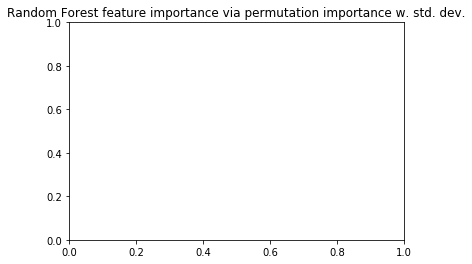

In [117]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.metrics import f1_score
imp_vals, imp_all = feature_importance_permutation(
    predict_method= base_model.predict_classes, 
    X=X_test_oh.values,
    y=y_test_le,
    metric=f1_score,
    num_rounds=10,
    seed=1)


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Random Forest feature importance via permutation importance w. std. dev.")
plt.bar(range(X.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()